In [10]:
import sklearn
sklearn.__version__
import pandas_profiling
import pandas as pd
from matplotlib import pyplot as plt
from numpy import mean
import time
from sklearn.tree import DecisionTreeClassifier, plot_tree
from joblib import parallel_backend
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from io import StringIO
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import cross_val_score

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

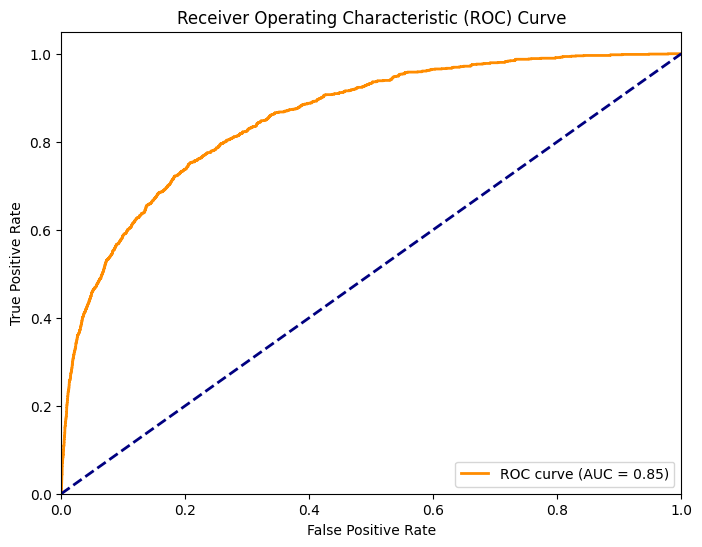

Model ROC AUC: 0.85
Baseline ROC AUC (Random Guessing): 0.50
Accuracy on train set: 0.9227714285714286
Accuracy on test set: 0.9216667
Cross-validation scores: [0.9226 0.917  0.9178 0.9224 0.9202 0.9216 0.9232 0.9208 0.9218 0.9212]
Mean accuracy: 0.92086


In [12]:
#READ AND DROP RECORDID/FEATURE EXCLUSION

df1 = pd.read_csv("train.csv")
df1 = df1.drop(columns=['RecordID','hospital_id','icu_id'])

#CHECKING FOR MULTICOLINEARITY
profile= pandas_profiling.ProfileReport(df1)
# variables rejected due to high correlation
rejected_features= list(profile.get_rejected_variables())
df1= df1.drop(rejected_features,axis=1)
df1.shape


#Capturing Numerical Columnns
numerical_cols = df1.select_dtypes(include=['number']).columns
#OneHot Encoding
df1 = pd.get_dummies(df1)

#Capturing categorical columns after onehot encoding
categorical_cols = list(set(df1) - set(numerical_cols))

#NORMALIZING USING MINMAX

scaler = MinMaxScaler()
# Normalize the selected columns
df1[df1.columns] = scaler.fit_transform(df1[df1.columns])
df1.head()

#IMPUTATING MISSING VALUES OF NUMERICAL AND CATAGORICAL COLUMNS SEPARATELY FOR BETTER ACCURACY


# Impute numerical columns with mean
numerical_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
df1[numerical_cols] = numerical_imputer.fit_transform(df1[numerical_cols])

# Impute categorical columns with mode
categorical_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df1[categorical_cols] = categorical_imputer.fit_transform(df1[categorical_cols])
df1.head()
#Data and Target Variable
x = df1.loc[:, df1.columns != 'hospital_death']
y = df1[['hospital_death']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3,random_state=42)


# Create the Random Forest Classifier
clf = RandomForestClassifier(n_estimators=300, random_state=42, max_depth=5)

# Train the model on the training data
clf.fit(x_train, y_train)



y_pred = clf.predict_proba(x_test)[:, 1]

#Evaluation Metric, ROC and Baseline Prediction
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


random_predictions = np.random.rand(len(y_test))

#BASELINE PREDICTION METRICS: RANDOM GUESSING, MAJORITY CLASS, CONSTANT PREDICTON
# Calculate ROC AUC for the random guessing baseline

y_train = y_train.astype(int)

baseline_roc_auc = roc_auc_score(y_test, random_predictions)
# Compare the model's ROC AUC to the baseline's ROC AUC
print(f"Model ROC AUC: {roc_auc:.2f}")
print(f"Baseline ROC AUC (Random Guessing): {baseline_roc_auc:.2f}")

#K-Fold Cross Validation
train_score = clf.score(x_train, y_train)
test_score = clf.score(x_test, y_test)
print("Accuracy on train set: {}".format(train_score))
print("Accuracy on test set: {}".format(round(test_score, 7)))

scores = cross_val_score(clf, x, y, cv=10)

# Print the accuracy scores for each fold and the mean accuracy
print("Cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())